In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Code Overview:
- First Task: Process the images from all of the datasets (akeic/bcc, bkl, mel, nv, other, vasc) into dataframes, reshape, augment, and batch
- Second Task: Define model structure and find Optimal Parameters with Hyperband
- Second Task: Train Model with optimal parameters
- Third Task: Visualize Results

---
**Task 1:** Processing the images

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import keras_tuner as kt

In [3]:
tf.random.set_seed(19)
np.random.seed(19)

In [4]:
# Import Data
data_name = "skin_cancer_master_gray_filtered"
cancer_data = keras.utils.image_dataset_from_directory(data_name, labels="inferred", image_size=(600,600), batch_size=None)

Found 28089 files belonging to 6 classes.


In [5]:
# Split Data
cancer_data.shuffle(cancer_data.cardinality())
#Take 75% of images for training
train_images = cancer_data.take(21552)
#Split training set for validation set
val_images = train_images.skip(10761)

#Smaller portion for tuning
tuning_images = train_images.take(5380)

#Remaining 25% for test
test_images = cancer_data.skip(21552) 

In [6]:
#reshape images and one-hot encode
size = (196, 196)
train_ds = train_images.map(lambda x, y: (tf.image.resize(x, size), [int(y == index) for index in range(6)]))
validation_ds = val_images.map(lambda x, y: (tf.image.resize(x, size), [int(y == index) for index in range(6)]))
test_ds = test_images.map(lambda x, y: (tf.image.resize(x, size), [int(y == index) for index in range(6)]))

tuning_ds = tuning_images.map(lambda x, y: (tf.image.resize(x, size), [int(y == index) for index in range(6)]))

#Augment train_ds
flipped_ds = train_ds.map(lambda x, y: (tf.keras.layers.RandomFlip("horizontal")(x, training=True), y))
# rotated_ds = train_ds.map(lambda x, y: (tf.keras.layers.RandomRotation(0.2)(x, training=True), y)) #Insufficient Resources to Augment Further
train_ds = train_ds.concatenate(flipped_ds)#.concatenate(rotated_ds)

In [7]:
## Setup prefetching of size 2
batch_size = 2
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=2)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=2)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=2)
tuning_ds = tuning_ds.cache().batch(batch_size).prefetch(buffer_size=2)

---
**Task 2:** Define Model Structure and find Optimal Parameters with Hyperband

In [8]:
def build_model(hp):
    # From Keras load the Xception model
    base_model = keras.applications.Xception(
        weights="imagenet",  # load the model with ImageNet weights
        input_shape=(196, 196, 3), 
        include_top=False, # Remove classifier layer
    )
    
    base_model.trainable = False  
    
    # Define Keras sequential model
    inputs = keras.Input(shape=(196, 196, 3))
    # Rescale inputs from (0, 255) to range of (-1., +1.)
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)
    
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)

    #Tunable layers
    x = tf.keras.layers.Dropout(rate = hp.Float('rate_1', min_value=0.1, max_value=0.4, default=0.2))(x)
    x = tf.keras.layers.Dense(units = hp.Int('units_1', min_value=64, max_value=512, step=32), activation='relu')(x)    
    
    outputs = keras.layers.Dense(6, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    #Tunable Learning rate choices
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'],
    )

    return model

In [9]:
#Define tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     seed=19,
                     directory='hpm',
                     project_name='skin_cancer_classification',
                     overwrite=True)

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [9]:
#Find optimal parameters
tuner.search(tuning_ds, epochs=1, validation_data=validation_ds, callbacks=[callback])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal configuration found is:\n
\tDropout Rate: {best_hps.get('rate_1')}\n
\tHidden 1 Nodes: {best_hps.get('units_1')}\n
\tLearning Rate: {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 14m 43s]
val_accuracy: 0.7708275318145752

Best val_accuracy So Far: 0.7765730619430542
Total elapsed time: 03h 54m 08s

The optimal configuration found is:

	Dropout Rate: 0.3935064575112991

	Hidden 1 Nodes: 352

	Learning Rate: 0.0001.



---
**Task 3:** Train with optimal parameters

In [11]:
model = tuner.hypermodel.build(best_hps)
model.fit(train_ds, epochs=50, validation_data=validation_ds, callbacks=[callback])

Epoch 1/50
21552/21552 [==============================] - 532s 24ms/step - loss: 0.7359 - accuracy: 0.7638 - val_loss: 0.6164 - val_accuracy: 0.7984
Epoch 2/50
21552/21552 [==============================] - 516s 24ms/step - loss: 0.6422 - accuracy: 0.7870 - val_loss: 0.5602 - val_accuracy: 0.8156
Epoch 3/50
21552/21552 [==============================] - 490s 23ms/step - loss: 0.5960 - accuracy: 0.7990 - val_loss: 0.5150 - val_accuracy: 0.8313
Epoch 4/50
21552/21552 [==============================] - 475s 22ms/step - loss: 0.5582 - accuracy: 0.8091 - val_loss: 0.4823 - val_accuracy: 0.8400
Epoch 5/50
21552/21552 [==============================] - 465s 22ms/step - loss: 0.5275 - accuracy: 0.8192 - val_loss: 0.4467 - val_accuracy: 0.8552
Epoch 6/50
21552/21552 [==============================] - 659s 31ms/step - loss: 0.5015 - accuracy: 0.8277 - val_loss: 0.4259 - val_accuracy: 0.8584
Epoch 7/50
21552/21552 [==============================] - 617s 29ms/step - loss: 0.4736 - accuracy: 0.8359

In [12]:
model.save(data_name + '.keras')

In [13]:
model = tf.keras.models.load_model(data_name + '.keras')

1/1 [==============================] - 0s 36ms/step


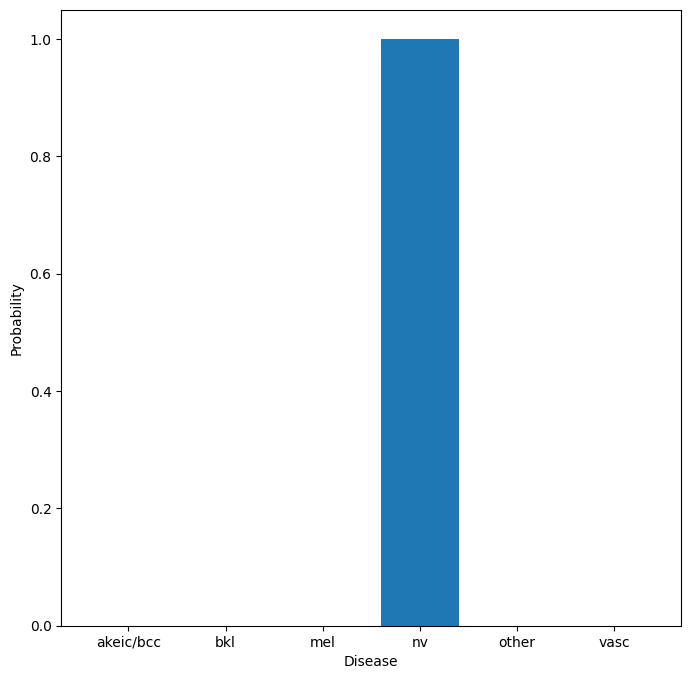

Actual: 3, Predicted: 3


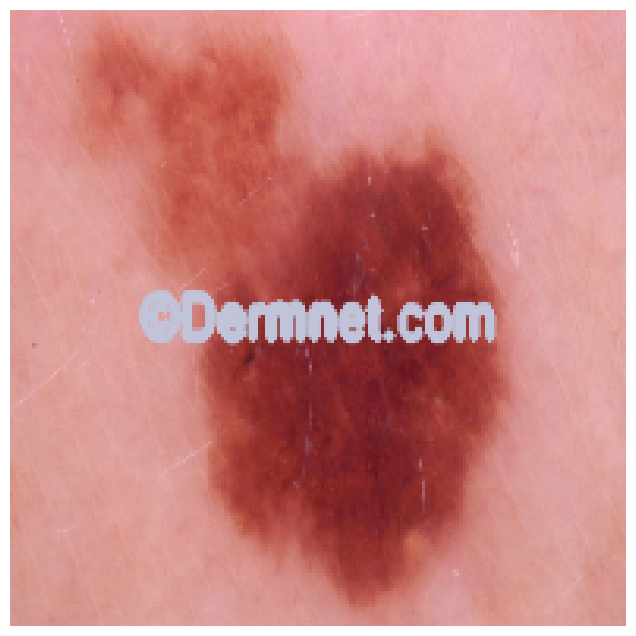

In [20]:
#Show one image example from the test set

import matplotlib.pyplot as plt

shuffled = test_ds.shuffle(test_ds.cardinality())

# Visualize results for first image from the first batch taken
for images, labels in shuffled.take(1):
    predicted_labels = model.predict(images)  # Predict labels for the batch

    # Normalize
    normalized_data = np.array(predicted_labels[0]) / sum(predicted_labels[0])
    
    # Plot the probability distribution for the first image
    plt.figure(figsize=(8, 8))
    plt.bar(range(len(normalized_data)), normalized_data)
    plt.xlabel('Disease')
    plt.ylabel('Probability')
    plt.xticks(range(len(normalized_data)), ["akeic/bcc", "bkl", "mel", "nv", "other", "vasc"])
    plt.show()

    # Display the first image
    plt.figure(figsize=(8, 8))
    plt.imshow(images[0].numpy() / 255.0)  # Normalize
    print(f"Actual: {np.argmax(labels[0].numpy())}, Predicted: {np.argmax(predicted_labels[0])}")
    plt.axis('off')
    plt.show()


In [15]:
#Get all predictions
predictions = model.predict(test_ds, verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

In [16]:
#Get true labels
true_labels = np.concatenate([labels.numpy() for images, labels in test_ds])
true_labels = np.argmax(true_labels, axis=1)

In [17]:
from sklearn.metrics import confusion_matrix

#Produce confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

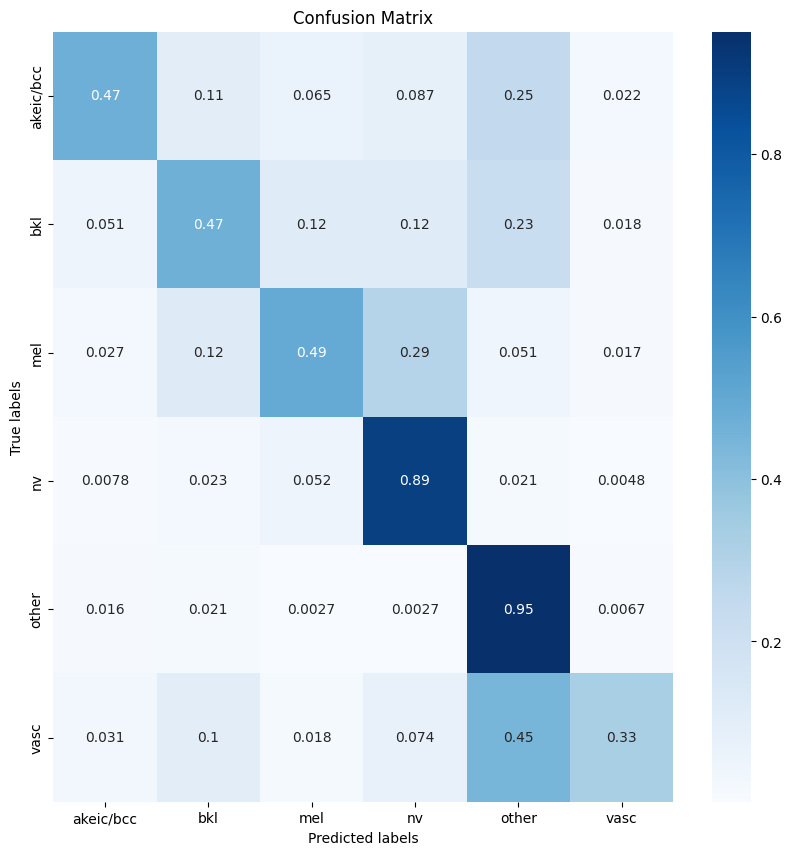

In [18]:
import seaborn as sns

#Visualize the cm
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", xticklabels=["akeic/bcc", "bkl", "mel", "nv", "other", "vasc"], yticklabels=["akeic/bcc", "bkl", "mel", "nv", "other", "vasc"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Print out model statistics

print(f"Accuracy: {accuracy_score(true_labels, predicted_labels, normalize=False) / len(true_labels)}")
print(f"Precision: {precision_score(true_labels, predicted_labels, average='macro')}")
print(f"Recall: {recall_score(true_labels, predicted_labels, average='macro')}")
print(f"F1 Score: {f1_score(true_labels, predicted_labels, average='macro')}")

Accuracy: 0.8167355055836011
Precision: 0.6524141597279848
Recall: 0.6000256520242885
F1 Score: 0.618894727138411
